In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [2]:
train = pd.read_csv('data/train.csv')
# drop id
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
features = [f for f in test.columns if not f.startswith('EC')]
targets = ['EC1', 'EC2']

train.head()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
0,0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,...,4.794537,35.527357,0,0,1,1,0,0,0,0
1,1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,...,13.825658,44.707310,0,0,0,1,1,0,0,0
2,2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,...,17.964475,45.660120,0,0,1,1,0,0,1,0
3,3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,...,31.961948,87.509997,0,0,1,1,0,0,0,0
4,4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,...,9.589074,33.333333,2,2,1,0,1,1,1,0


In [7]:
# checking for null values
train.isnull().sum().sum()>0, test.isnull().sum().sum()>0

(False, False)

In [3]:
# checking for duplicates
pd.concat([train, test]).duplicated().sum()

0

In [7]:
# integer type features
int_features = [f for f in features if train[f].dtype == 'int64'] # float type features
# drop id from int_features
int_features = int_features[1:]
float_features = [f for f in features if train[f].dtype == 'float64'] # object type features
print('int_features: ', int_features)
print('float_features: ', float_features)

int_features:  ['NumHeteroatoms', 'fr_COO', 'fr_COO2']
float_features:  ['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha', 'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9']


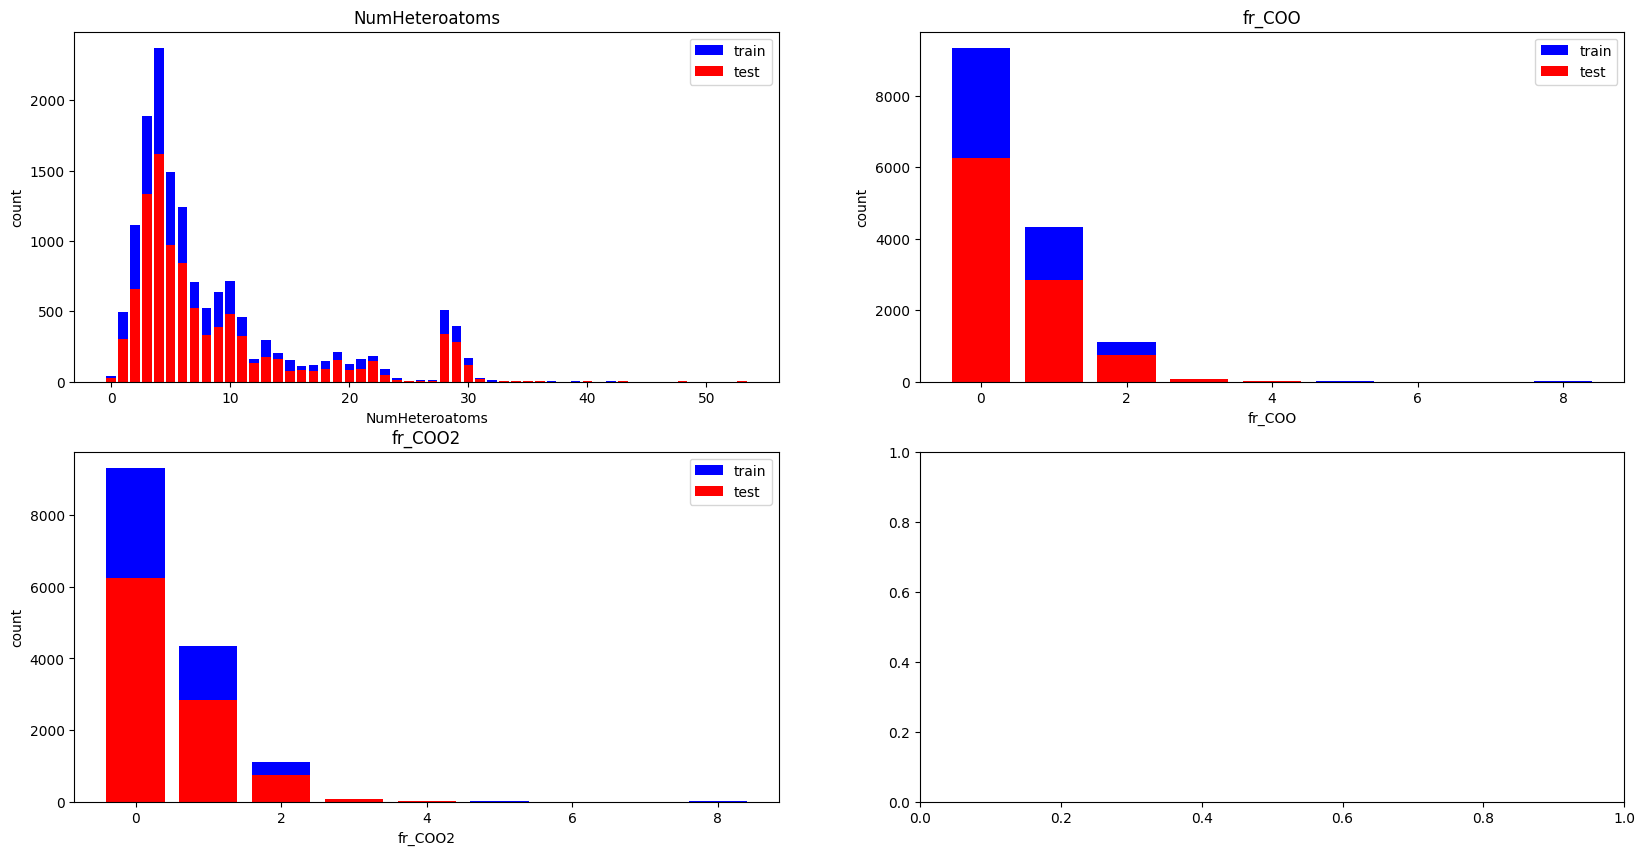

In [13]:
# bar plot int features
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for i, f in enumerate(int_features):
    plt.subplot(2, 2, i+1)
    plt.bar(train[f].value_counts().index, train[f].value_counts(), color='blue',label='train')
    plt.bar(test[f].value_counts().index, test[f].value_counts(), color='red',label='test')
    plt.title(f)
    plt.xlabel(f)
    plt.ylabel('count')
    plt.legend()
plt.show()
    




We can see train and test data has the same distribution

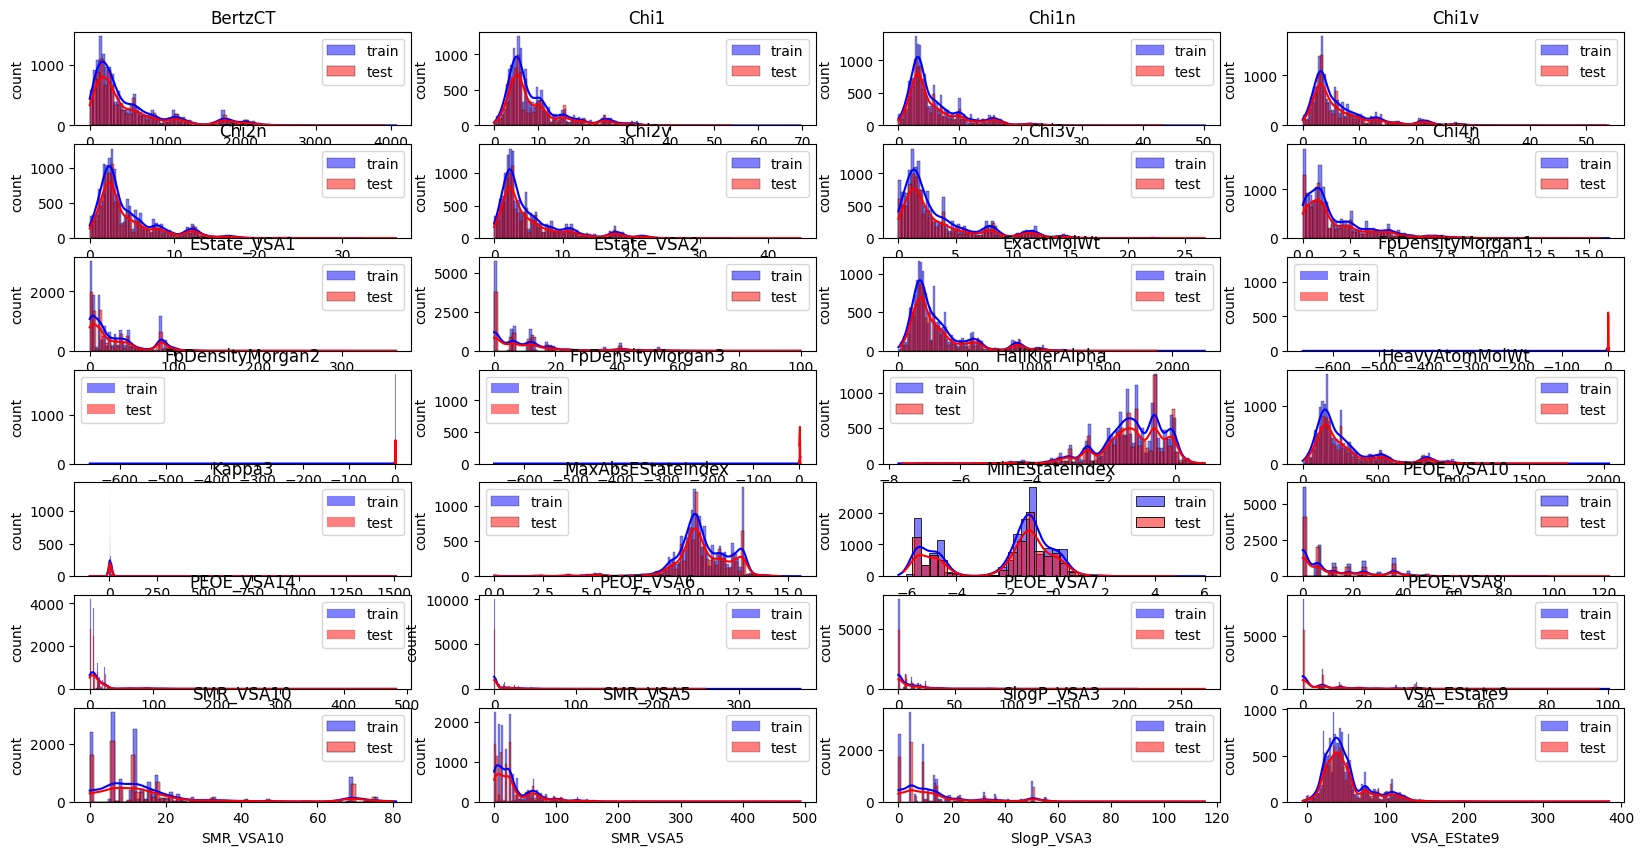

In [14]:
# histogram plot float features
fig, axes = plt.subplots(7,4, figsize=(20, 10))
for i, f in enumerate(float_features):
    plt.subplot(7, 4, i+1)
    sns.histplot(train[f], color='blue', label='train', kde=True)
    sns.histplot(test[f], color='red', label='test', kde=True)
    plt.title(f)
    plt.xlabel(f)
    plt.ylabel('count')
    plt.legend()


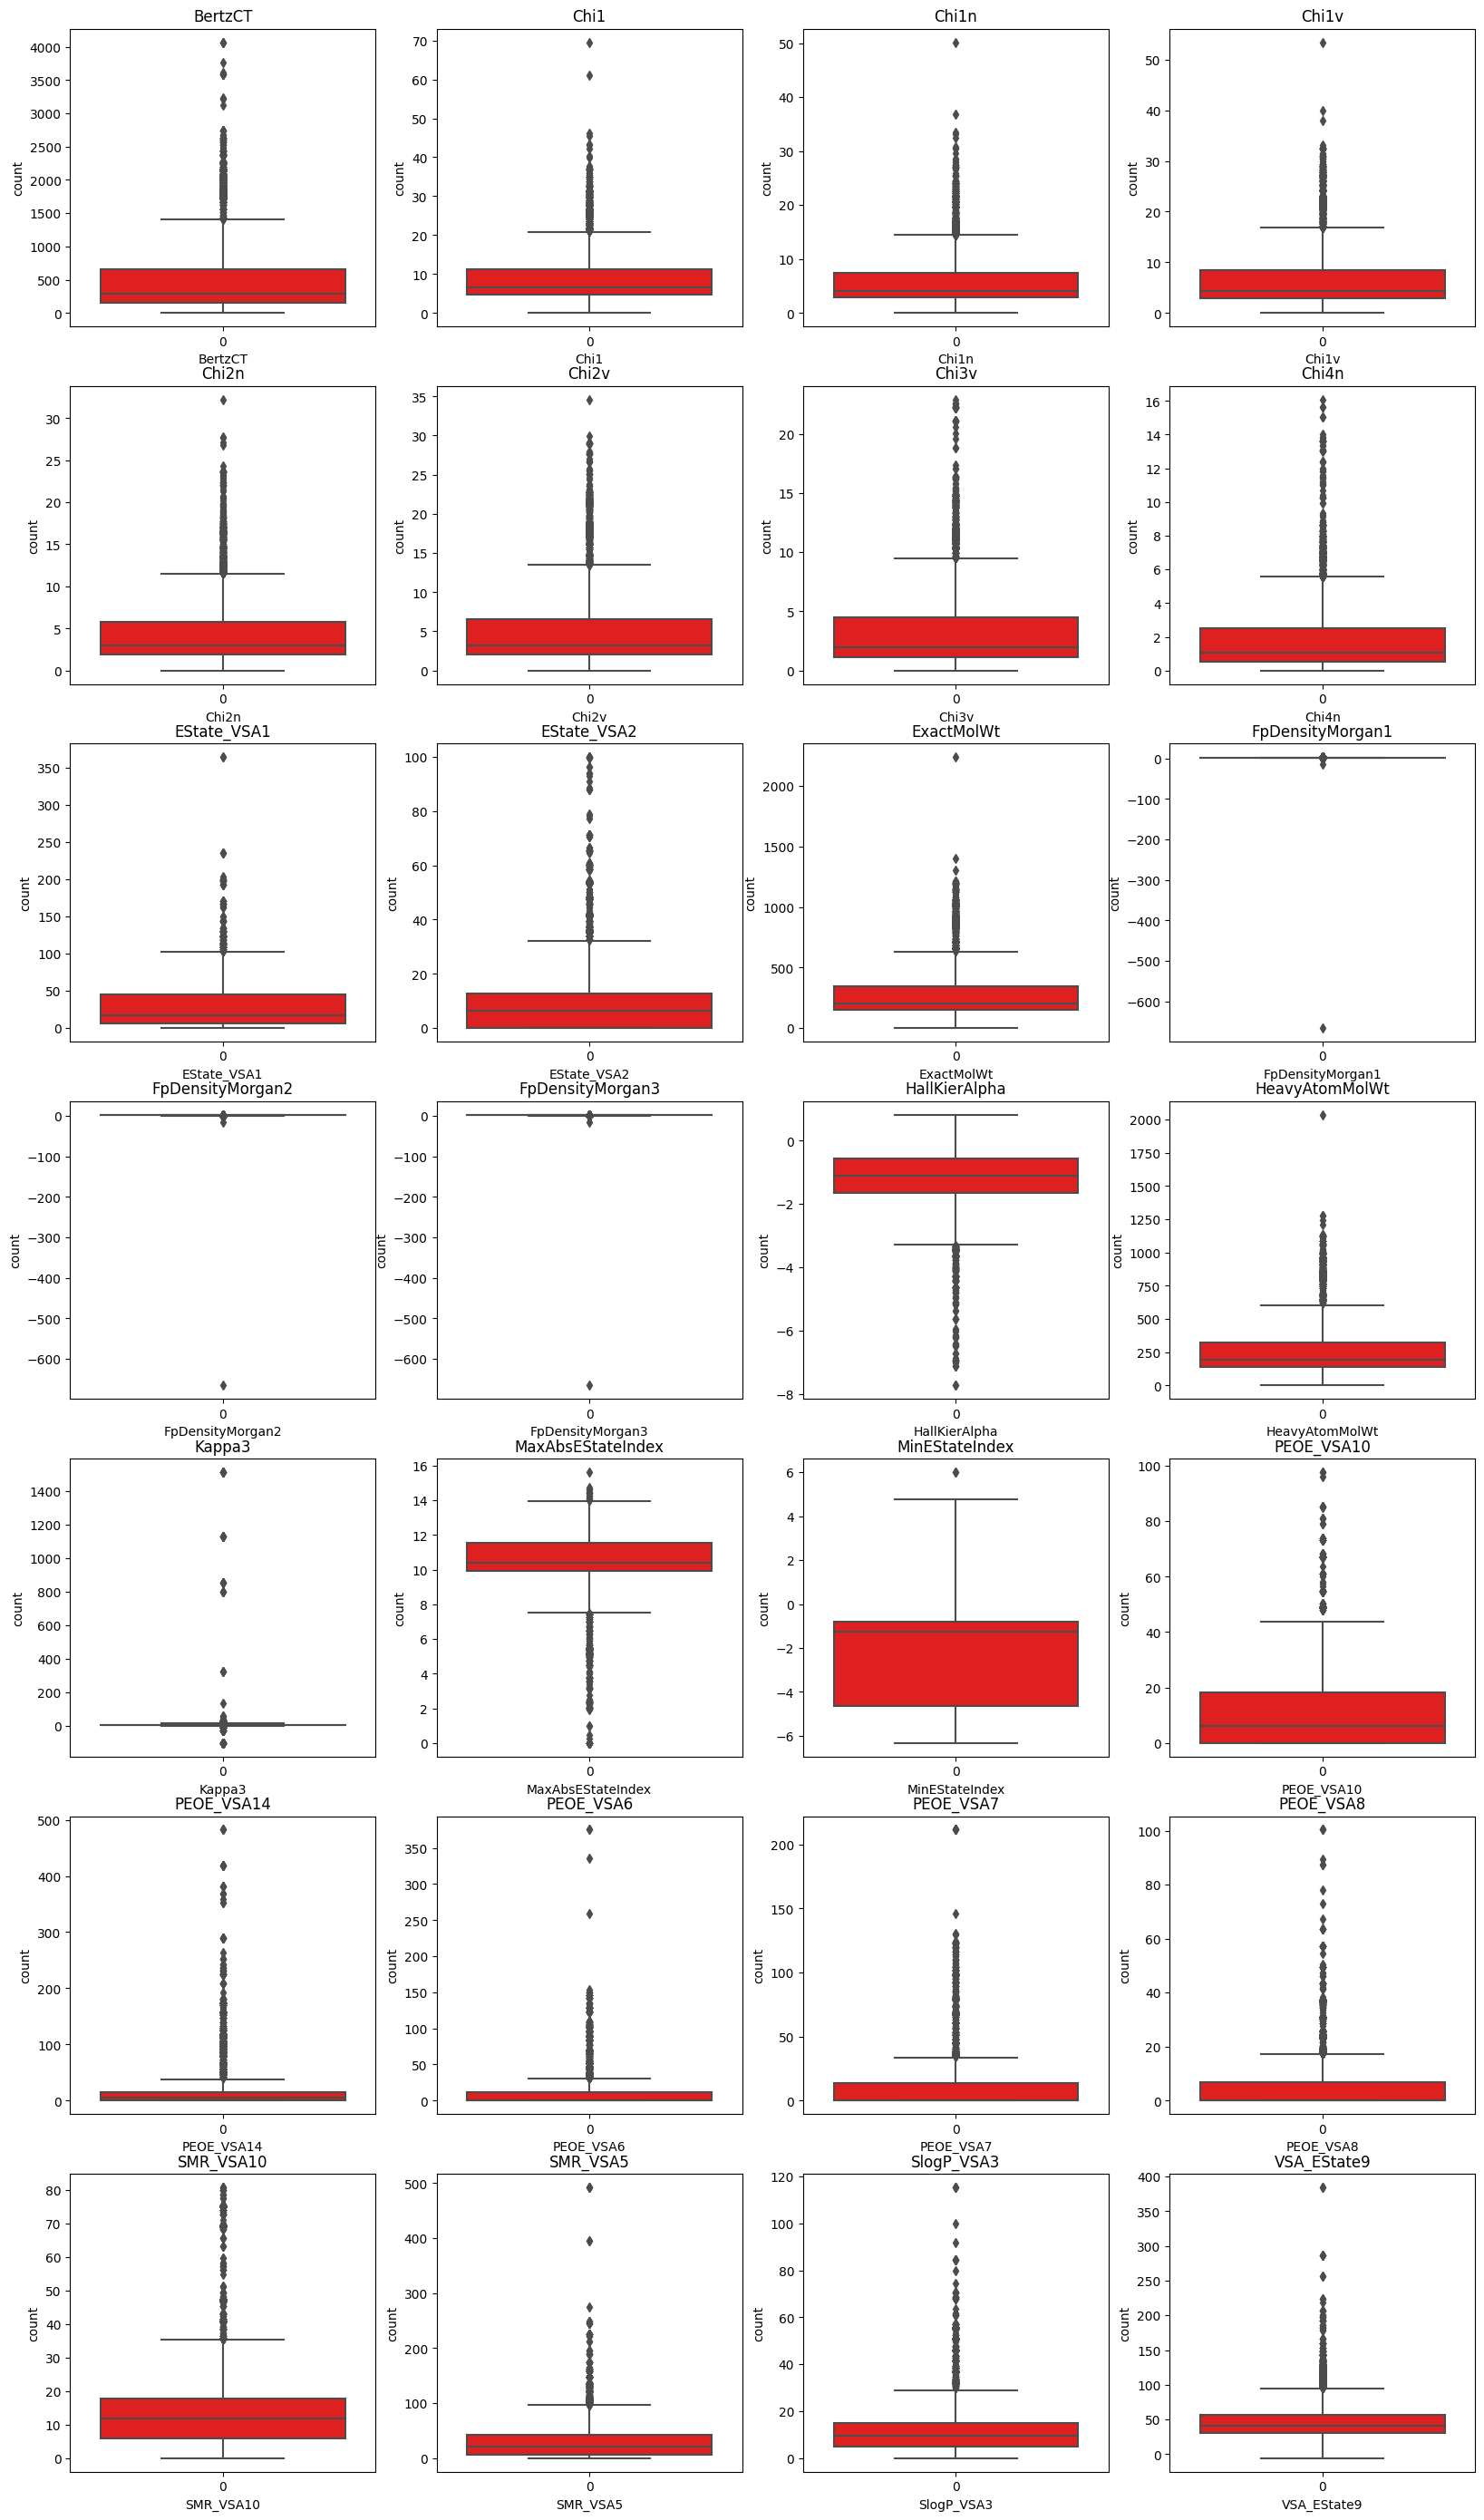

In [22]:
# box plot float features to check outliers
fig, axes = plt.subplots(7,4, figsize=(20, 35))
for i, f in enumerate(float_features):
    plt.subplot(7, 4, i+1)
    sns.boxplot(train[f], color='red')
    plt.title(f)
    plt.xlabel(f)
    plt.ylabel('count')


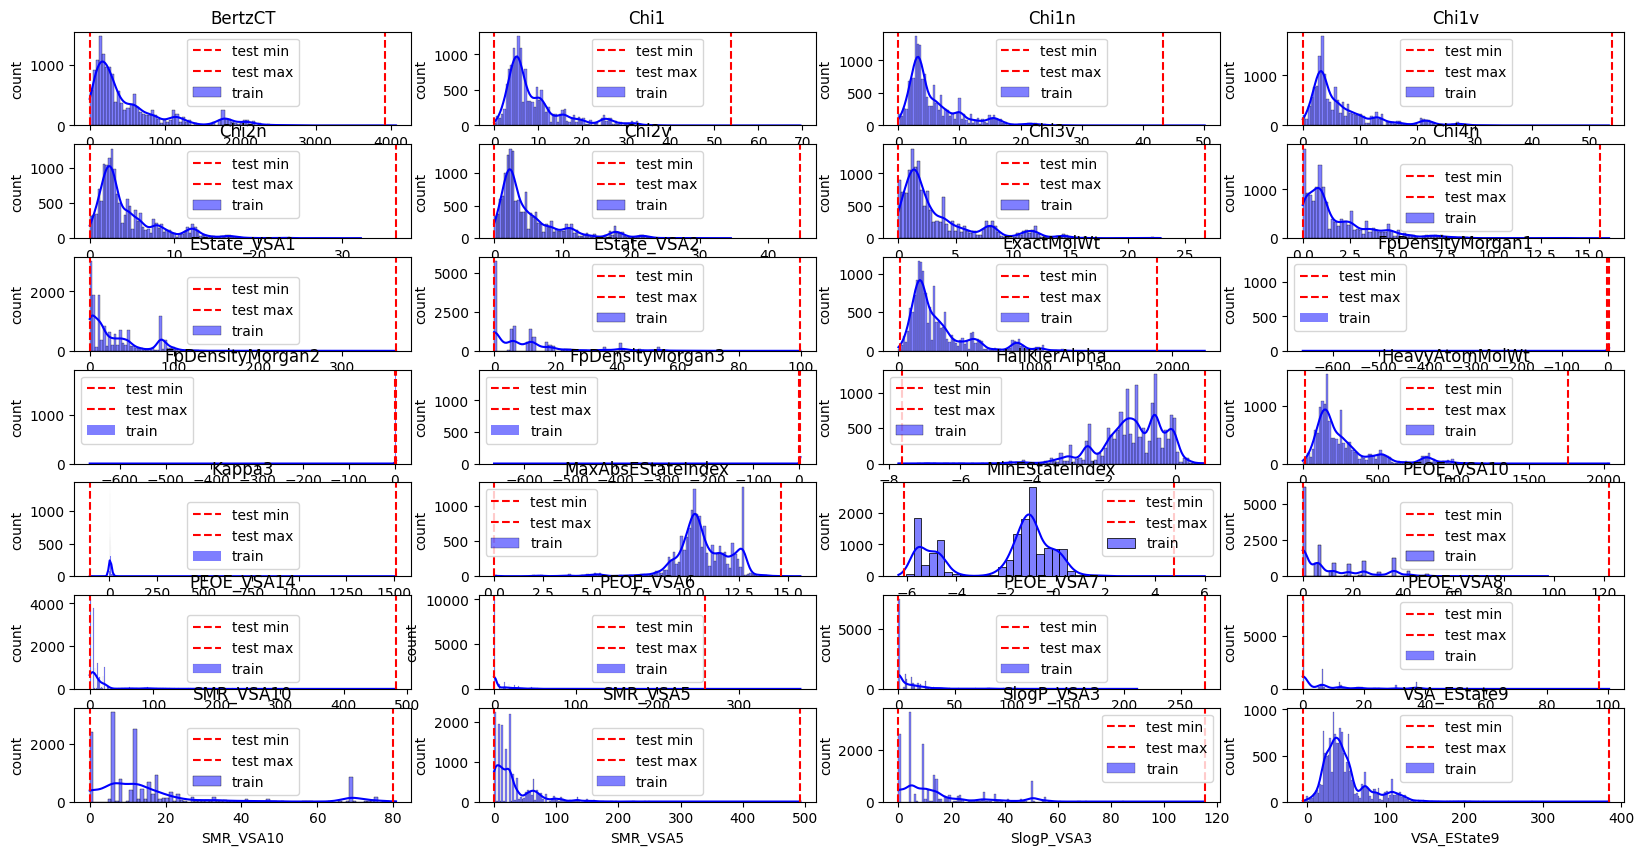

In [23]:
# histogram plot float features
fig, axes = plt.subplots(7,4, figsize=(20, 10))
for i, f in enumerate(float_features):
    plt.subplot(7, 4, i+1)
    sns.histplot(train[f], color='blue', label='train', kde=True)
    # show vertical line as min or max from test
    plt.axvline(test[f].min(), color='red', linestyle='--', label='test min')
    plt.axvline(test[f].max(), color='red', linestyle='--', label='test max')
    plt.title(f)
    plt.xlabel(f)
    plt.ylabel('count')
    plt.legend()


In [24]:
print(train['FpDensityMorgan2'].sort_values().rename('train'))
print()
print(test['FpDensityMorgan2'].sort_values().rename('test'))

3422    -666.000000
12572    -14.458462
10020     -5.111111
6348       0.000000
6636       0.350000
            ...    
13259      3.111111
3537       3.111111
10877      3.111111
9128       3.166667
13431      3.200000
Name: train, Length: 14838, dtype: float64

369     0.416667
3308    0.416667
7039    0.450000
9610    0.475000
538     0.500000
          ...   
1522    3.047619
821     3.066667
9229    3.125000
3193    3.125000
7074    3.200000
Name: test, Length: 9893, dtype: float64


In [25]:
# model for EC1
cv = StratifiedKFold(shuffle=True, random_state=1)


In [37]:
l=[]
for min_samples_leaf in range(10, 100, 5):
    model = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=min_samples_leaf, random_state=1)
    scores = cross_val_score(model, train[features], train['EC1'], cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    l.append((min_samples_leaf, scores))

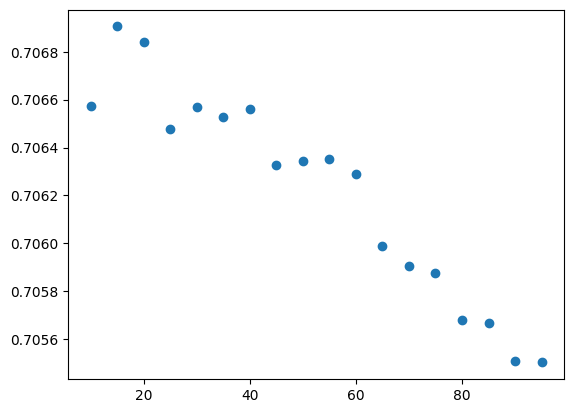

In [41]:
plt.scatter(list(zip(*l))[0], list(zip(*l))[1])
argmax = np.argmax(list(zip(*l))[1])
best_min_samples_leaf = list(zip(*l))[0][argmax]

In [43]:
# model for EC2
lst = []
lgbm_params1 = {'n_estimators': 579,
               'colsample_bytree': 0.12,
               'reg_lambda': 5,
               'min_child_samples': 11,
               'num_leaves': 7,
               'learning_rate': 0.01}
model = LGBMClassifier(**lgbm_params1)
scores = cross_val_score(model, train[features], train['EC2'], cv=cv, scoring='roc_auc', n_jobs=-1).mean()
print(scores)


0.5870466465918057


In [47]:
model_ec1 = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=best_min_samples_leaf, random_state=1)
model_ec1.fit(train[features], train['EC1'])
pred_ec1 = model_ec1.predict_proba(test[features])[:, 1]
model_ec2 = LGBMClassifier(**lgbm_params1)
model_ec2.fit(train[features], train['EC2'])
pred_ec2 = model_ec2.predict_proba(test[features])[:, 1]
sub = pd.DataFrame({'EC1': pred_ec1, 'EC2': pred_ec2}, index=test['id'])

In [48]:
competition_name = "playground-series-s3e18"
sub.to_csv('submission.csv')
message = "RF submission"
!kaggle competitions submit -c {competition_name} -f submission.csv -m "{message}"

100%|█████████████████████████████████████████| 424k/424k [00:00<00:00, 483kB/s]
Successfully submitted to Explore Multi-Label Classification with an Enzyme Substrate Dataset